# Deep Learning Assignment 3 - Part 2
### Latent Space Visualization


# Imports

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.animation as animation
from IPython.display import Video
from google.colab import files
import seaborn as sns
from sklearn.decomposition import PCA

# Preprocessing

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder Class

The `Encoder` takes input data and compresses it into a lower-dimensional latent space representation.

- **Layers**:
  - Two fully connected layers to gradually reduce dimensionality.
  - Separate layers for **mean (μ)** and **log variance (log σ²)** to model uncertainty.
- **Activation & Regularization**:
  - `LeakyReLU` ensures stable gradients.
  - `BatchNorm` normalizes activations, improving convergence.
  - `Dropout` prevents overfitting by randomly deactivating neurons.
- **Clipping**:
  - The log variance is clipped between `-5` and `5` to maintain numerical stability.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Extra hidden layer
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = self.batch_norm(F.leaky_relu(self.fc2(x), negative_slope=0.2))
        x = self.dropout(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x).clamp(-5, 5)  # Clipping to avoid instability
        return mu, logvar

# Decoder Class

The `Decoder` class takes a latent space representation and reconstructs it back into an image.

- It has multiple fully connected layers to gradually expand the compressed latent vector.
- **Activation Functions**:
  - `LeakyReLU` helps avoid dead neurons and ensures smooth learning.
  - `Sigmoid` is used at the output layer to keep pixel values between 0 and 1.
- **Batch Normalization** is applied to stabilize training and improve convergence.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim=784, hidden_dim=400, latent_dim=200):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Extra hidden layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = self.batch_norm(F.leaky_relu(self.fc2(x), negative_slope=0.2))
        x = torch.sigmoid(self.fc_out(x))
        return x

# Variational Auto Encoder Class

This class defines the **VAE model**, combining an **encoder**, **decoder**, and a **reparameterization trick** for learning a smooth latent space.

- **Initialization (`__init__`)**:
  - Instantiates the `Encoder` and `Decoder`.
  - Stores the device for computation (`cuda` or `cpu`).

- **Reparameterization Trick**:
  - Uses **mean (μ) and log variance (log σ²)** from the encoder.
  - Computes **standard deviation (σ)** using `torch.exp(0.5 * logvar)`.
  - Samples **ε ~ N(0, I)** to introduce randomness and generate `z = μ + σ * ε`.

- **Forward Pass**:
  - Passes `x` through the encoder to get `μ, logvar`.
  - Applies the **reparameterization trick** to sample `z`.
  - Feeds `z` into the decoder to reconstruct `x`.



In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device="cuda"):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)
        self.device = device

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        return mu + std * eps

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr = 1e-3)

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(f"Total Encoder Parameters: {sum(p.numel() for p in model.encoder.parameters())}")
print(f"Total Decoder Parameters: {sum(p.numel() for p in model.decoder.parameters())}")

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=400, bias=True)
    (fc_mu): Linear(in_features=400, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=400, out_features=200, bias=True)
    (batch_norm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=200, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=400, bias=True)
    (fc_out): Linear(in_features=400, out_features=784, bias=True)
    (batch_norm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number of parameters: 1191584
Total Encoder Parameters: 635600
Total Decoder Parameters: 555984


# Loss Function Class

In this section, we define the loss function for training the VAE. The loss function consists of two main components:

1. **BCE Loss**:  
   - Measures the reconstruction error between the original image \( x \) and the reconstructed image.
   - It ensures that the generated image is as close as possible to the original.  
   - The formula used:

  $$
  \text{BCE} = - \sum \left[ x \log(\hat{x} + 10^{-10}) + (1 - x) \log(1 - \hat{x} + 10^{-10}) \right]
  $$

2. **Kullback-Leibler (KL) Divergence Loss**:  
   - Encourages the learned latent distribution to be close to a normal Gaussian distribution.  
   - This regularization helps improve the generative capabilities of the model.  
   - The formula used:

  $$
  \text{KLD} = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \exp(\log \sigma^2) \right)
  $$

The final loss function is the sum of the **BCE loss** and the **KL divergence loss**, ensuring a balance between **accurate reconstruction** and **latent space regularization**.

  $$
  \mathcal{L} = \text{BCE} + \text{KLD}
  $$



In [ ]:
def loss_function(x, x_hat, mean, log_var):
    # BCE
    loss_reprod = -torch.sum(x * torch.log(x_hat + 1e-10) + (1 - x) * torch.log(1 - x_hat + 1e-10))

    # KL Divergence Loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return loss_reprod + KLD


# Training Loop

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = overall_loss / (batch_idx * batch_size)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Average Loss: {overall_loss / (batch_idx * batch_size)}")

        #  Evaluation Step
        if (epoch + 1) % 10 == 0:
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for x, _ in test_loader:
                    x = x.view(batch_size, x_dim).to(device)
                    x_hat, mean, log_var = model(x)
                    val_loss = loss_function(x, x_hat, mean, log_var)
                    total_val_loss += val_loss.item()

                avg_val_loss = total_val_loss / len(test_loader)
                val_losses.append(avg_val_loss)
                print(f"--- Validation Loss after {epoch + 1} epochs: {total_val_loss / len(test_loader)} ---")

            #  Generate and Plot an Image
            with torch.no_grad():
                sample, _ = next(iter(test_loader))  # Take a random test sample
                sample = sample.view(batch_size, x_dim).to(device)
                mean, log_var = model.encoder(sample)  # Encode sample
                z = model.reparameterize(mean, log_var)
                generated = model.decoder(z)  # Decode back to image
                generated = generated.view(batch_size, 28, 28).cpu().numpy()

            plt.imshow(generated[0], cmap="gray")
            plt.title(f"Generated Image at Epoch {epoch + 1}")
            plt.axis("off")
            plt.show()

            model.train()

    return train_losses, val_losses


Epoch 1, Average Loss: 192.3531128541058
Epoch 2, Average Loss: 129.88308163345158
Epoch 3, Average Loss: 118.4694870682909
Epoch 4, Average Loss: 115.08127613405155
Epoch 5, Average Loss: 113.31403799626982
Epoch 6, Average Loss: 112.20590088298205
Epoch 7, Average Loss: 111.40294533858514
Epoch 8, Average Loss: 110.63711155963064
Epoch 9, Average Loss: 110.24511374752191
Epoch 10, Average Loss: 109.66465420883765
--- Validation Loss after 10 epochs: 10477.84050455729 ---


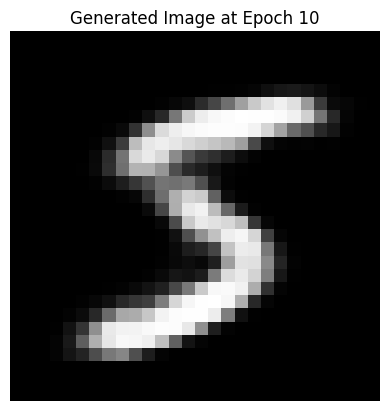

Epoch 11, Average Loss: 109.20493873252296
Epoch 12, Average Loss: 108.9137422559735
Epoch 13, Average Loss: 108.64019170948977
Epoch 14, Average Loss: 108.20920738666005
Epoch 15, Average Loss: 108.0091615909328
Epoch 16, Average Loss: 107.64943957702943
Epoch 17, Average Loss: 107.41176236109662
Epoch 18, Average Loss: 107.25635900328673
Epoch 19, Average Loss: 106.96601330994366
Epoch 20, Average Loss: 106.81680471684578
--- Validation Loss after 20 epochs: 10214.868126627603 ---


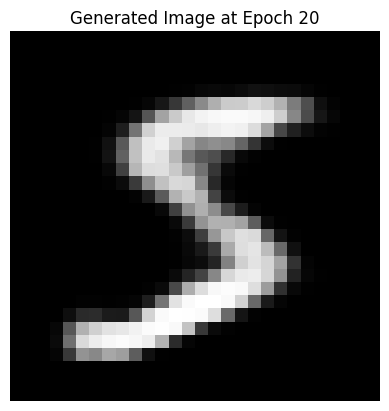

Epoch 21, Average Loss: 106.66773585859245
Epoch 22, Average Loss: 106.48020038279945
Epoch 23, Average Loss: 106.40999523946161
Epoch 24, Average Loss: 106.11126682491653
Epoch 25, Average Loss: 106.10324274180927
Epoch 26, Average Loss: 105.93669484948873
Epoch 27, Average Loss: 105.75565105253547
Epoch 28, Average Loss: 105.61197950359976
Epoch 29, Average Loss: 105.62122826781615
Epoch 30, Average Loss: 105.50815317195325
--- Validation Loss after 30 epochs: 10084.349736328126 ---


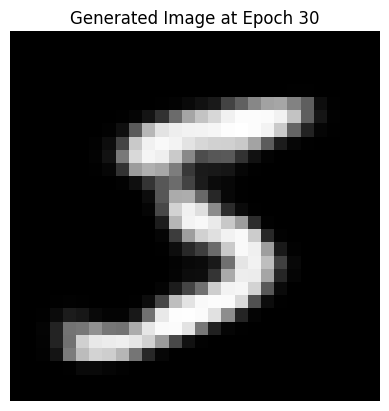

Epoch 31, Average Loss: 105.41651298714002
Epoch 32, Average Loss: 105.33579838467759
Epoch 33, Average Loss: 105.20142915601524
Epoch 34, Average Loss: 105.16439580290067
Epoch 35, Average Loss: 105.00386203568448
Epoch 36, Average Loss: 104.8970475532137
Epoch 37, Average Loss: 104.79653162171327
Epoch 38, Average Loss: 104.69554302744157
Epoch 39, Average Loss: 104.67449062239149
Epoch 40, Average Loss: 104.63340357301232
--- Validation Loss after 40 epochs: 9991.996207682292 ---


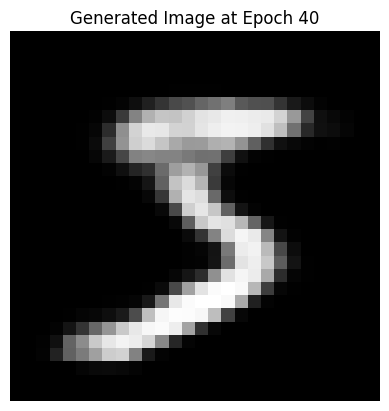

Epoch 41, Average Loss: 104.5040385668823
Epoch 42, Average Loss: 104.51459620200333
Epoch 43, Average Loss: 104.43747507238626
Epoch 44, Average Loss: 104.32451263172997
Epoch 45, Average Loss: 104.35874675566048
Epoch 46, Average Loss: 104.27486275954716
Epoch 47, Average Loss: 104.16253055222245
Epoch 48, Average Loss: 104.08051195351628
Epoch 49, Average Loss: 104.00794511034015
Epoch 50, Average Loss: 104.00057551974645
--- Validation Loss after 50 epochs: 9941.934002278645 ---


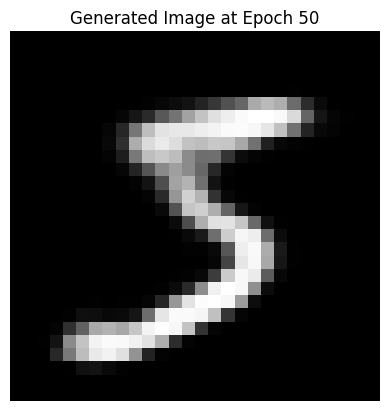

In [ ]:
train_losses, val_losses = train(model, optimizer, epochs=50, device=device)

# Loss Visualization Over Training Epochs

This cell plots the training and validation losses over the epochs.


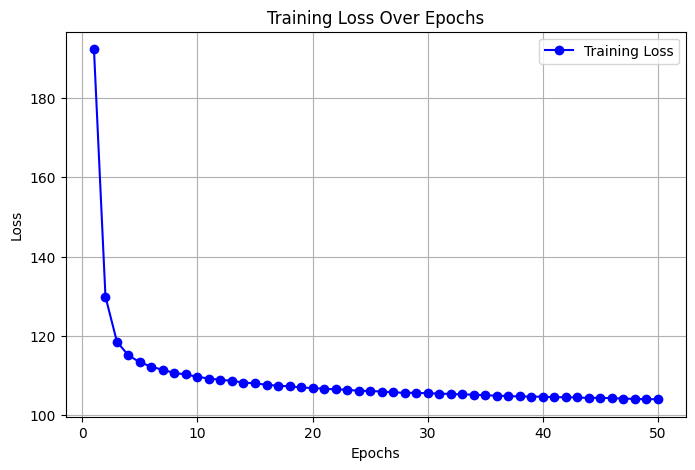

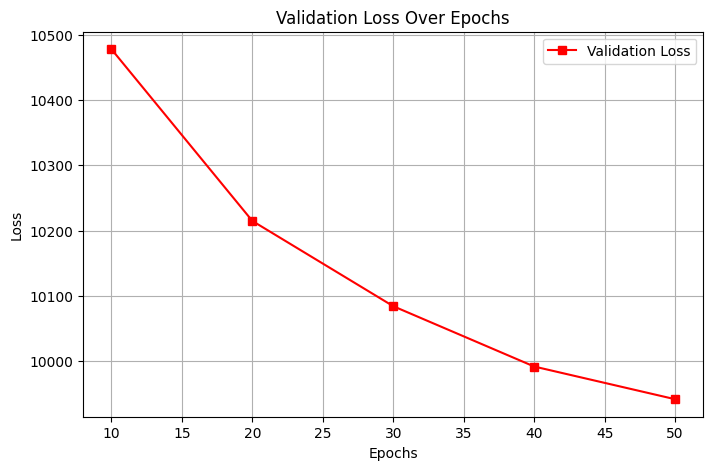

In [ ]:
def plot_losses(train_losses, val_losses, epochs):
    # Plot Training Loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='blue', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")
    # Plot Validation Loss
    if val_losses:
        plt.figure(figsize=(8, 5))
        plt.plot(range(10, epochs + 1, 10), val_losses, label="Validation Loss", color='red', marker='s')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Validation Loss Over Epochs")
        plt.legend()
        plt.grid()
        plt.show()

plot_losses(train_losses, val_losses, 50)

# Generate and plot digit

In this section, we generate and visualize digits from the latent space of the trained VAE. By sampling from a normal distribution with specified mean and variance, we create latent vectors, decode them using the VAE’s decoder, and display the corresponding generated images.


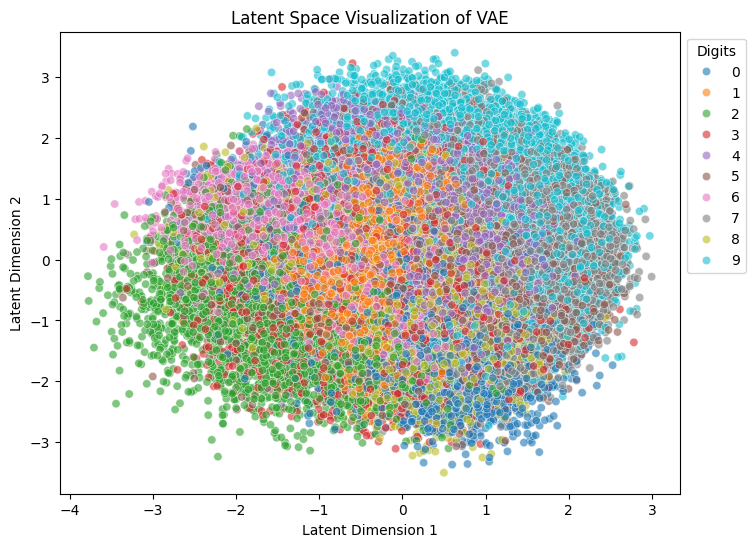

In [ ]:
def get_latent_space(model, dataloader, device):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.view(images.size(0), -1).to(device)
            mu, logvar = model.encoder(images)
            latents.append(mu.cpu())
            labels.append(targets.cpu())
    return torch.cat(latents), torch.cat(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
latent_vectors, digit_labels = get_latent_space(model, test_loader, device)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_latents = pca.fit_transform(latent_vectors.numpy())

# Scatter plot of latent space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_latents[:, 0], y=reduced_latents[:, 1], hue=digit_labels.numpy(), palette="tab10", alpha=0.6)
plt.title("Latent Space Visualization of VAE")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title="Digits", bbox_to_anchor=(1, 1))
plt.show()

def generate_digit(mean, var):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    latent_dim = 200  # Matches the latent space dimension

    # Expand scalar mean/var to the full latent space size
    mean = torch.full((1, latent_dim), mean, device=device)
    var = torch.full((1, latent_dim), var, device=device)

    # Reparameterization trick
    std = torch.exp(0.5 * var)
    eps = torch.randn_like(std)
    z = mean + eps * std

    # Decode the latent vector
    with torch.no_grad():
        generated_img = model.decoder(z).cpu().view(28, 28)

    plt.imshow(generated_img, cmap='gray')
    plt.axis('off')
    plt.show()

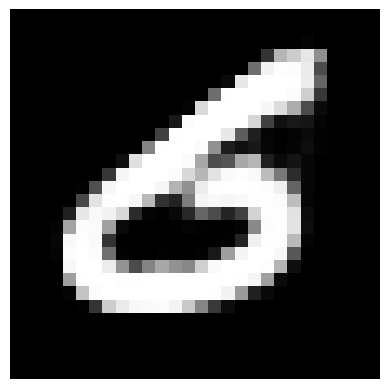

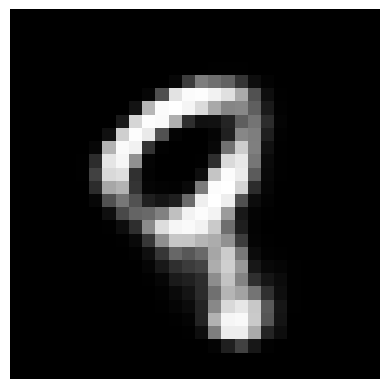

(None, None)

In [ ]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

# Latent Space Grid Visualization

This function visualizes the latent space by generating a grid of digits. It systematically samples points in a 2D grid from the latent space, setting the first two dimensions based on the grid values while randomly sampling the rest. The decoder then reconstructs the corresponding images, which are displayed as a single grid to showcase variations in the learned latent space.


In [ ]:
def plot_latent_space(model, scale, digit_size=28, figsize=7):
    latent_dim = 200
    grid_size = 10
    grid_x = np.linspace(-scale, scale, grid_size)
    grid_y = np.linspace(-scale, scale, grid_size)

    figure = np.zeros((digit_size * grid_size, digit_size * grid_size))

    # Generate digits for each position in the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.zeros((1, latent_dim), dtype=torch.float32).to(device)

            # Set first two dimensions using grid coordinates
            z_sample[0, 0] = xi
            z_sample[0, 1] = yi

            # Randomly sample remaining latent dimensions
            # z_sample[0, 2:] = torch.randn(1, latent_dim - 2).to(device)
            z_sample[:, 2:] = torch.randn(1, latent_dim-2).to(device)


            with torch.no_grad():
                generated = model.decoder(z_sample)  # Decode the latent point

            digit = generated.view(digit_size, digit_size).cpu().numpy()
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # Plot the digit grid
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="gray")
    plt.title(f"Latent Space Visualization (Scale={scale})")
    plt.axis("off")
    plt.show()

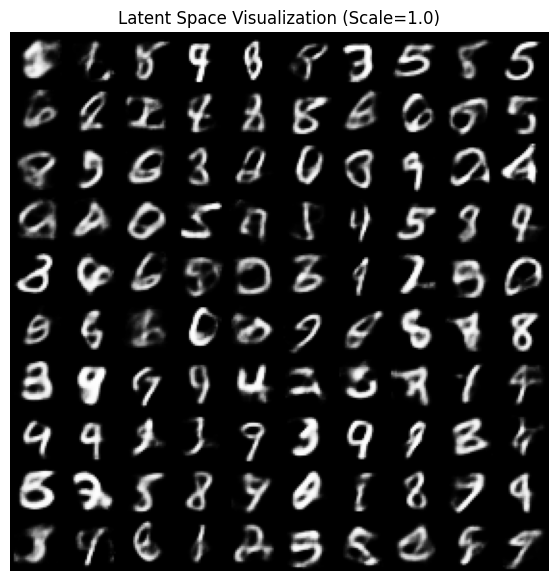

In [ ]:
plot_latent_space(model, scale=1.0)

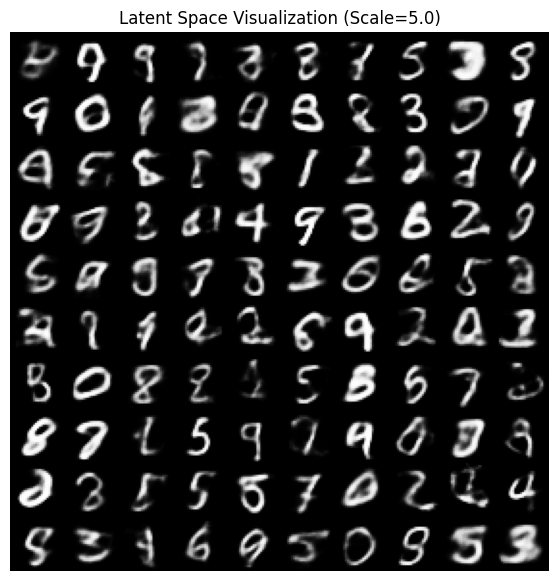

In [ ]:
plot_latent_space(model, scale=5.0)

# Linear Interpolation

In this section, we explore how different digits are represented in the **latent space** by interpolating between two randomly selected latent vectors.

#### **What it Does:**
- We sample **two random latent vectors** from the prior distribution.
- We generate **interpolated latent vectors** using:

  $$
  \hat{z} = (1 - t)z_1 + t z_2, \quad t \in [0,1]
  $$

- We **decode** these interpolated latent vectors into images.
- Finally, we **visualize** the smooth transition from one digit to another.

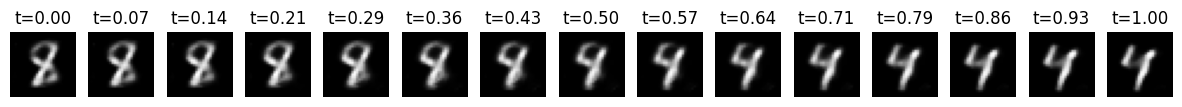

In [ ]:
def interpolate_digits(model, num_steps=10):
    latent_dim = 200

    # Sample two different random latent vectors from the prior
    z1 = torch.randn((1, latent_dim)).to(device)
    z2 = torch.randn((1, latent_dim)).to(device)

    while torch.norm(z1 - z2) < 5.0:  # If too close, resample
        z2 = torch.randn((1, latent_dim)).to(device)

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 2))

    for i, t in enumerate(np.linspace(0, 1, num_steps)):
        z_interp = (1 - t) * z1 + t * z2  # Compute interpolated latent vector

        with torch.no_grad():
            generated = model.decoder(z_interp)  # Decode into image

        digit = generated.view(28, 28).cpu().numpy()  # Convert to numpy

        axes[i].imshow(digit, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"t={t:.2f}")

    plt.show()

interpolate_digits(model, num_steps=15)


# Bonus: Rendering a Video of Latent Space Interpolation

In this section, we create a **video animation** of the latent space interpolation to visualize how our VAE smoothly transitions between two digits.

####  **What We Are Doing**
- We **select two real images** from the dataset and encode them into latent space.
- We **linearly interpolate** between the two latent vectors:
  
  $$\hat{x} = (1 - t) x_1 + t x_2, \quad t \in [0,1]$$

- For each interpolation step, we **decode the latent vector** back into an image.
- We **combine all frames into a video**, saving it as `bonus.mp4`.



Video saved as bonus.mp4


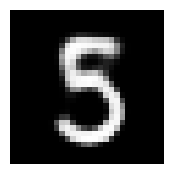

In [ ]:
def interpolate_digits_video(model, num_steps=20, filename="bonus.mp4"):
    latent_dim = 200

    # Select two real encoded digits instead of random ones
    x_batch, _ = next(iter(train_loader))
    x1, x2 = x_batch[0].to(device), x_batch[1].to(device)

    with torch.no_grad():
        mean1, log_var1 = model.encoder(x1.view(1, -1))
        mean2, log_var2 = model.encoder(x2.view(1, -1))

        std1 = torch.exp(0.5 * log_var1)
        std2 = torch.exp(0.5 * log_var2)

        z1 = mean1 + std1 * torch.randn_like(std1)
        z2 = mean2 + std2 * torch.randn_like(std2)


    fig, ax = plt.subplots(figsize=(2, 2))
    images = []

    for t in np.linspace(0, 1, num_steps):
        z_interp = (1 - t) * z1 + t * z2  # Linear interpolation in latent space

        with torch.no_grad():
            generated = model.decoder(z_interp)  # Decode to image

        digit = generated.view(28, 28).cpu().numpy()  # Convert to numpy

        img = ax.imshow(digit, cmap="gray", animated=True)
        ax.axis("off")
        images.append([img])

    ani = animation.ArtistAnimation(fig, images, interval=100, blit=True)
    ani.save(filename, writer="ffmpeg")

    print(f"Video saved as {filename}")

interpolate_digits_video(model, num_steps=100)

In [ ]:
Video("bonus.mp4", embed=True)

In [ ]:
from google.colab import drive
from IPython.display import Video

drive.mount('/content/drive')
video_path = "/content/drive/MyDrive/bonus.mp4"
Video(video_path, embed=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import base64
from IPython.display import HTML

from google.colab import drive
from IPython.display import Video

drive.mount('/content/drive')

video_path = "/content/drive/MyDrive/bonus.mp4"

# Read and encode the video in Base64
with open(video_path, "rb") as f:
    video_data = f.read()
    video_base64 = base64.b64encode(video_data).decode("utf-8")

# Display the embedded video
html_code = f'''
<video width="600" height="400" controls>
    <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    Your browser does not support the video tag.
</video>
'''

HTML(html_code)

Mounted at /content/drive
